In [2]:
#Importing Libraries
import tensorflow 
import numpy as np 
import pandas as pd 
from collections import Counter
import random
import IPython
from IPython.display import Image, Audio
import music21
from music21 import *
import matplotlib.pyplot as plt 
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
import tensorflow.keras.backend as K
from tensorflow.keras.optimizers import Adamax
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
%matplotlib inline
import sys
import warnings
import os
warnings.filterwarnings("ignore")
warnings.simplefilter("ignore")
np.random.seed(42)

import keras
from keras.callbacks import ModelCheckpoint, EarlyStopping
from keras.utils.vis_utils import plot_model


In [3]:
#téléchargement de la base de donnée
filepath = "./BDD/"
#Liste de tous les fichiers midi 
all_midis= []
for i in os.listdir(filepath):
    if i.endswith(".mid"):
        tr = filepath+i
        midi = converter.parse(tr)
        all_midis.append(midi)

In [4]:
#Fonction extraction des notes d'un dossier de plusieurs fichiers
def extract_notes(file):
    notes = []
    pick = None
    for j in file:
        songs = instrument.partitionByInstrument(j)
        for part in songs.parts:
            pick = part.recurse()
            for element in pick:
                if isinstance(element, note.Note):
                    notes.append(str(element.pitch))
                elif isinstance(element, chord.Chord):
                    notes.append(".".join(str(n) for n in element.normalOrder))

    return notes

#Création du corpus des notes de tous les fichier midi 
Corpus= extract_notes(all_midis)
print("Total des notes de trompettes dans la base de donnée", len(Corpus))

Total des notes de trompettes dans la base de donnée 18377


In [5]:
print(type(Corpus))
print("50 première note du corpus", Corpus[:50])


<class 'list'>
50 première note du corpus ['B-3', 'E-4', 'G4', 'F4', 'E-4', 'G4', 'F4', 'E-4', 'C4', 'B-3', 'B-3', 'E-4', 'G4', 'F4', 'E-4', 'G4', 'F4', 'B-4', 'B-4', 'G4', 'B-4', 'G4', 'B-4', 'G4', 'E-4', 'B-3', 'C4', 'E-4', 'E-4', 'C4', 'B-3', 'B-3', 'E-4', 'G4', 'F4', 'E-4', 'G4', 'F4', 'E-4', 'E-4', '3.7.10', '3.7.10', '3.7', '10.3', '8.10.2', '0.3.7', '3.8', '3.7', '3.7.10', '3.7.10']


In [6]:
# Création d'une partition musicale à partir d'une liste de notes
def show(notes):

    partition = stream.Score()

    # Ajout des notes à la partition
    for n in notes:
        print(notes)
        note_obj = note.Note(n)
        partition.append(note_obj)

    from music21 import environment
    environment.set('musescoreDirectPNGPath', r"C:\Program Files\MuseScore 3\bin\MuseScore3.exe")

    # Affichage de la partition
    partition.show()

In [7]:
# création d'une fonction qui sépare les accords des notes
def chords_n_notes(Snippet):
    Melody = []
    offset = 0 
    for i in Snippet:
        #si i est un accord
        print(i)
        if ("." in i or i.isdigit()):
            chord_notes = i.split(".") #Separation d'un accord en notes 
            notes = [] 
            for j in chord_notes:
                inst_note=int(j)
                note_snip = note.Note(inst_note)            
                notes.append(note_snip)
                chord_snip = chord.Chord(notes)
                chord_snip.offset = offset
                Melody.append(chord_snip)

        else: 
            note_snip = note.Note(i)
            note_snip.offset = offset
            Melody.append(note_snip)
     
        offset += 1
    Melody_midi = stream.Stream(Melody)   
    return Melody_midi

Melody_Snippet = chords_n_notes(Corpus[:100])

B-3
E-4
G4
F4
E-4
G4
F4
E-4
C4
B-3
B-3
E-4
G4
F4
E-4
G4
F4
B-4
B-4
G4
B-4
G4
B-4
G4
E-4
B-3
C4
E-4
E-4
C4
B-3
B-3
E-4
G4
F4
E-4
G4
F4
E-4
E-4
3.7.10
3.7.10
3.7
10.3
8.10.2
0.3.7
3.8
3.7
3.7.10
3.7.10
3.7
3.7.10
2.5.8
10
3.7
2.5
10
10
3.7.10
3.7.10
3.7.10
3.7.10
3.8
8.0.3
3.7
10.2
0.3.7
0.3.7
3.7.10
8.10.2
8.0.3
3.7.10
G#3
G#3
C4
G#3
G#3
C4
C#4
C4
B-3
E-4
E-4
E-4
F4
E-4
E-4
B-3
C4
B-3
G#3
G#3
G#3
C4
G#3
G#3
C4
C#4
C4
B-3


In [8]:
#Creation d'un disctionnaire de comptes
count_num = Counter(Corpus)
print("Total des notes différentes dans le coprus:", len(count_num))

Total des notes différentes dans le coprus: 222


In [9]:
#Exploration du disctionnaire
Notes = list(count_num.keys())
Recurrence = list(count_num.values())
#Les recurrences des notes
def Average(lst):
    return sum(lst) / len(lst)
print("Moyenne des récurrences des notes du corpus:", Average(Recurrence))
print("Frequence d'apparition de la note la plus présente:", max(Recurrence), "fois")
print("Frequence d'apparition de la note la moins présente:", min(Recurrence), "fois")

Moyenne des récurrences des notes du corpus: 82.77927927927928
Frequence d'apparition de la note la plus présente: 1531 fois
Frequence d'apparition de la note la moins présente: 1 fois


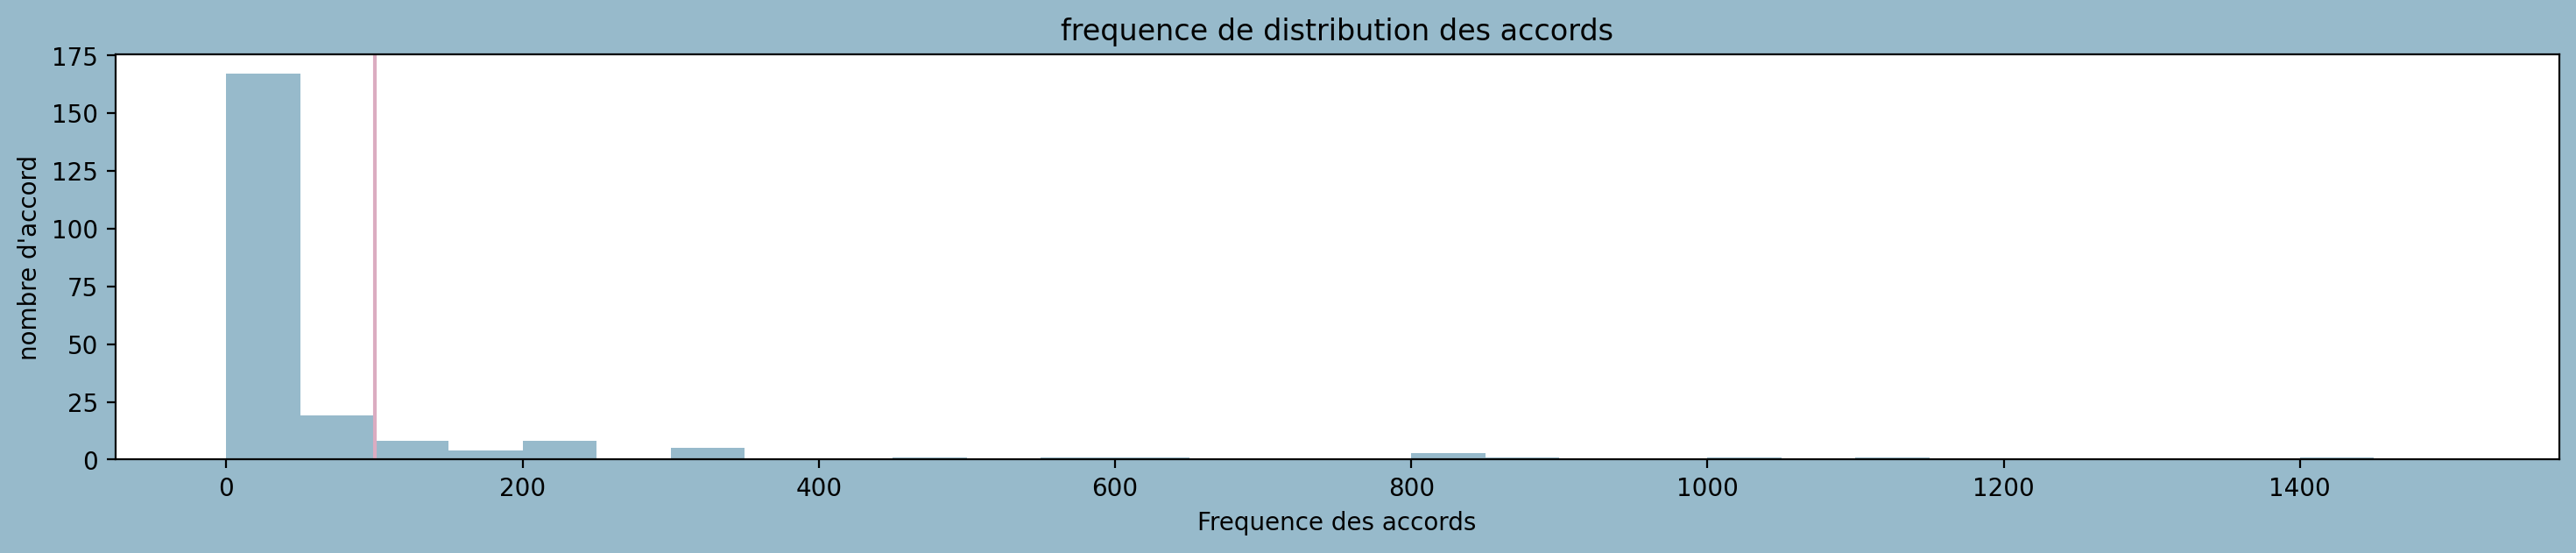

In [10]:
# affichage de la répartition des notes
plt.figure(figsize=(18,3),facecolor="#97BACB")
bins = np.arange(0,(max(Recurrence)), 50) 
plt.hist(Recurrence, bins=bins, color="#97BACB")
plt.axvline(x=100,color="#DBACC1")
plt.title("frequence de distribution des accords")
plt.xlabel("Frequence des accords")
plt.ylabel("nombre d'accord")
plt.show()

In [11]:
#récupération des accords rares
rare_note = []
for index, (key, value) in enumerate(count_num.items()):
    if value < 100:
        m =  key
        rare_note.append(m)
        
print("nombres d'accord apparaissant moins de 100 fois:", len(rare_note))

nombres d'accord apparaissant moins de 100 fois: 186


In [12]:
#elimination des notes rares dans le corpus
for element in Corpus:
    if element in rare_note:
        Corpus.remove(element)

print("Length of Corpus after elemination the rare notes:", len(Corpus))

Length of Corpus after elemination the rare notes: 16240


DATA PROCESSING


In [13]:
# Storing all the unique characters present in my corpus to bult a mapping dic. 
symb = sorted(list(set(Corpus)))

L_corpus = len(Corpus) #length of corpus
L_symb = len(symb) #length of total unique characters

#Building dictionary to access the vocabulary from indices and vice versa
mapping = dict((c, i) for i, c in enumerate(symb))
reverse_mapping = dict((i, c) for i, c in enumerate(symb))

print("Total number of characters:", L_corpus)
print("Number of unique characters:", L_symb)

Total number of characters: 16240
Number of unique characters: 189


In [14]:
#Splitting the Corpus in equal length of strings and output target
length = 40
features = []
targets = []
for i in range(0, L_corpus - length, 1):
    feature = Corpus[i:i + length]
    target = Corpus[i + length]
    features.append([mapping[j] for j in feature])
    targets.append(mapping[target])
    
    
L_datapoints = len(targets)
print("Total number of sequences in the Corpus:", L_datapoints)

Total number of sequences in the Corpus: 16200


In [15]:
# reshape X and normalize
X = (np.reshape(features, (L_datapoints, length, 1)))/ float(L_symb)
# one hot encode the output variable
y = tensorflow.keras.utils.to_categorical(targets) 

In [16]:
#Taking out a subset of data to be used as seed
X_train, X_seed, y_train, y_seed = train_test_split(X, y, test_size=0.2, random_state=42)

MODEL BUILDING

In [17]:
#Initialising the Model
model = Sequential()
#Adding layers
model.add(LSTM(512, input_shape=(X.shape[1], X.shape[2]), return_sequences=True))
model.add(Dropout(0.1))
model.add(LSTM(256))
model.add(Dense(256))
model.add(Dropout(0.1))
model.add(Dense(y.shape[1], activation='softmax'))
#Compiling the model for training  
opt = Adamax(learning_rate=0.01)
model.compile(loss='categorical_crossentropy', optimizer=opt)


In [18]:
#Model's Summary               
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 40, 512)           1052672   
                                                                 
 dropout (Dropout)           (None, 40, 512)           0         
                                                                 
 lstm_1 (LSTM)               (None, 256)               787456    
                                                                 
 dense (Dense)               (None, 256)               65792     
                                                                 
 dropout_1 (Dropout)         (None, 256)               0         
                                                                 
 dense_1 (Dense)             (None, 189)               48573     
                                                                 
Total params: 1,954,493
Trainable params: 1,954,493
Non-

In [19]:
plot_model(model, to_file='./model.png', show_shapes = True, show_layer_names = True)

You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model to work.


In [20]:
#Training the Model
history = model.fit(X_train, y_train, batch_size=256, epochs=5)

Epoch 1/5
51/51 [==============================] - 184s 4s/step - loss: 3.9130
Epoch 2/5
51/51 [==============================] - 193s 4s/step - loss: 3.6330
Epoch 3/5
51/51 [==============================] - 182s 4s/step - loss: 3.6269
Epoch 4/5
51/51 [==============================] - 159s 3s/step - loss: 3.6202
Epoch 5/5
51/51 [==============================] - 174s 3s/step - loss: 3.6178


EVALUATING MODELS

[Text(0.5, 0, 'Epochs')]

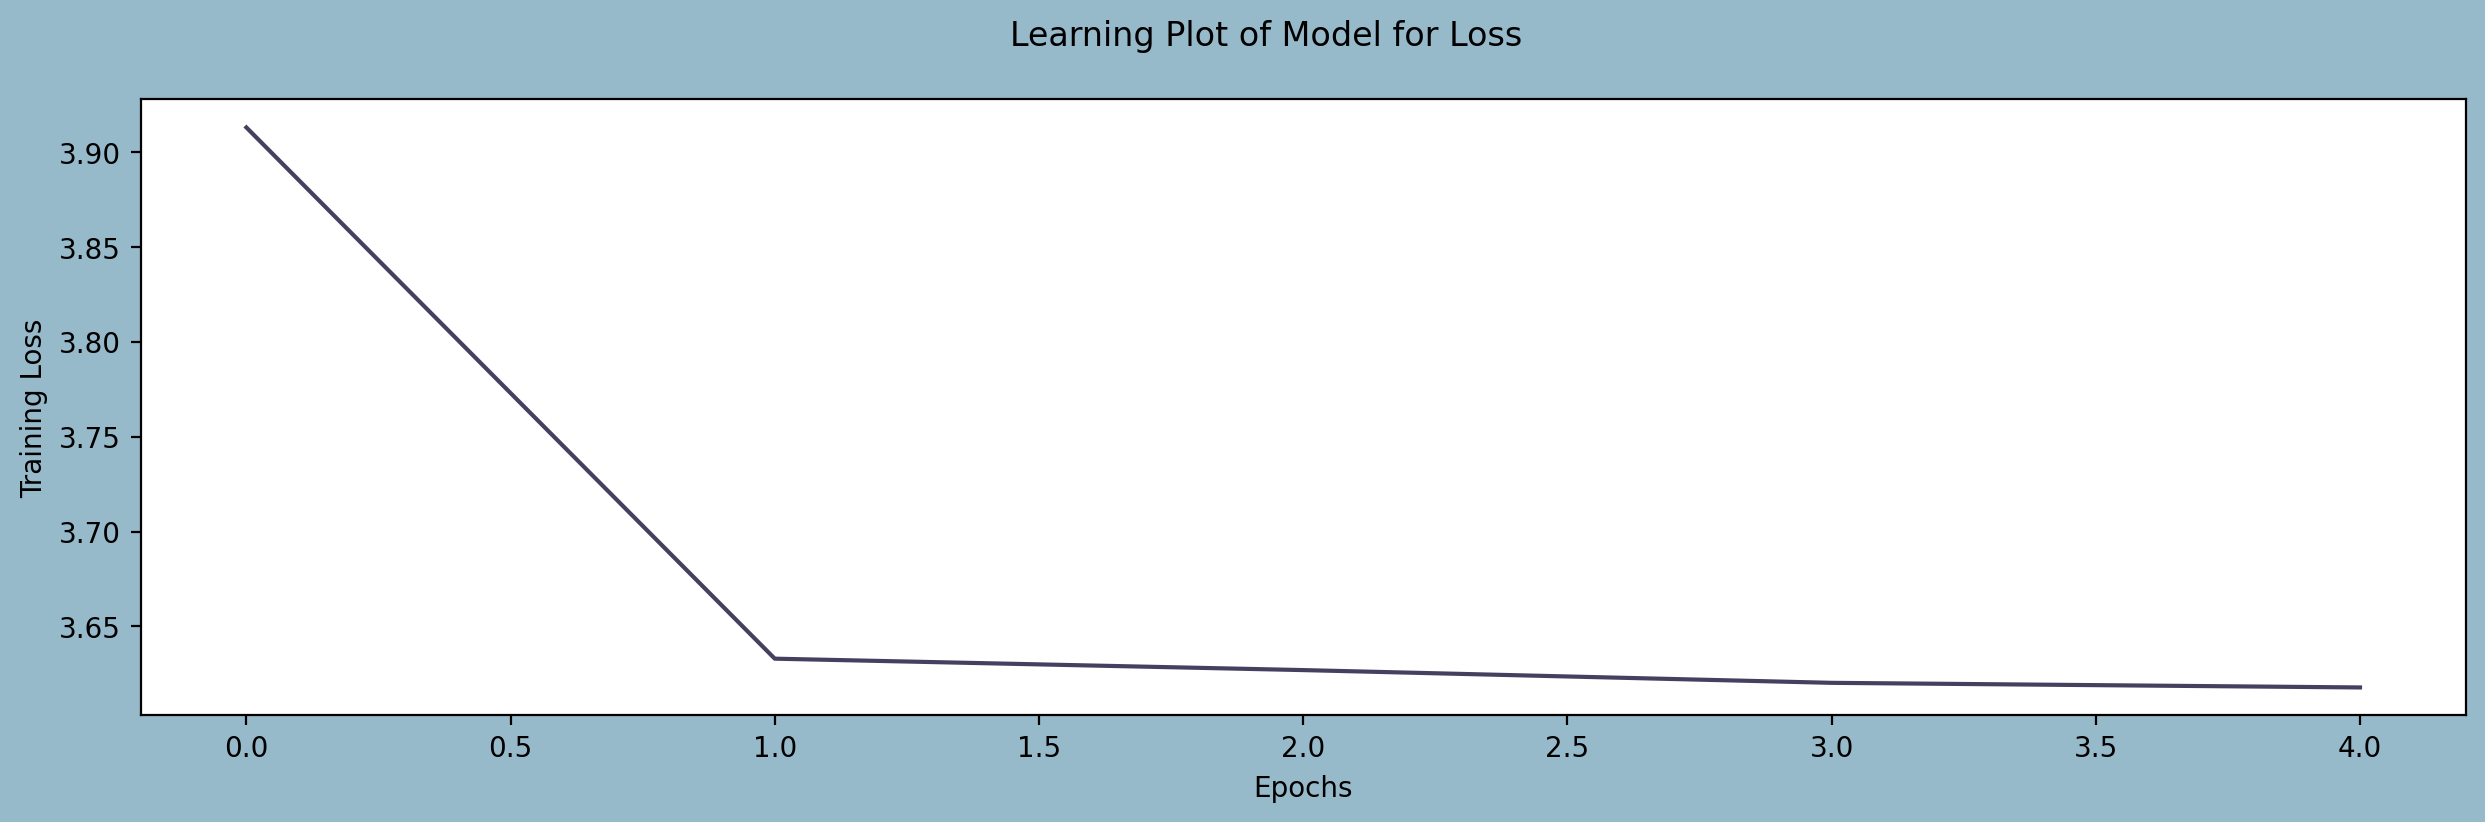

In [21]:
#Plotting the learnings 
history_df = pd.DataFrame(history.history)
fig = plt.figure(figsize=(15,4), facecolor="#97BACB")
fig.suptitle("Learning Plot of Model for Loss")
pl=sns.lineplot(data=history_df["loss"],color="#444160")
pl.set(ylabel ="Training Loss")
pl.set(xlabel ="Epochs")

In [22]:
def Malody_Generator(Note_Count):
    seed = X_seed[np.random.randint(0,len(X_seed)-1)]
    Music = ""
    Notes_Generated=[]
    for i in range(Note_Count):
        seed = seed.reshape(1,length,1)
        prediction = model.predict(seed, verbose=0)[0]
        prediction = np.log(prediction) / 1.0 #diversity
        exp_preds = np.exp(prediction)
        prediction = exp_preds / np.sum(exp_preds)
        index = np.argmax(prediction)
        index_N = index/ float(L_symb)   
        Notes_Generated.append(index)
        Music = [reverse_mapping[char] for char in Notes_Generated]
        seed = np.insert(seed[0],len(seed[0]),index_N)
        seed = seed[1:]
    #Now, we have music in form or a list of chords and notes and we want to be a midi file.
    Melody = chords_n_notes(Music)
    Melody_midi = stream.Stream(Melody)   
    return Music,Melody_midi




In [23]:
#getting the Notes and Melody created by the model
Music_notes, Melody = Malody_Generator(100)


F4
F4
F4
F4
F4
F4
F4
F4
F4
F4
F4
F4
F4
F4
F4
F4
F4
F4
F4
F4
F4
F4
F4
F4
F4
F4
F4
F4
F4
F4
F4
F4
F4
F4
F4
F4
F4
F4
F4
F4
F4
F4
F4
F4
F4
F4
F4
F4
F4
F4
F4
F4
F4
F4
F4
F4
F4
F4
F4
F4
F4
F4
F4
F4
F4
F4
F4
F4
F4
F4
F4
F4
F4
F4
F4
F4
F4
F4
F4
F4
F4
F4
F4
F4
F4
F4
F4
F4
F4
F4
F4
F4
F4
F4
F4
F4
F4
F4
F4
F4


In [24]:
print(type(Music_notes), type(Melody))
show(Melody)

<class 'list'> <class 'music21.stream.base.Stream'>
<music21.stream.Stream 0x2264e15ebc0>


TypeError: int() argument must be a string, a bytes-like object or a real number, not 'Stream'

In [ ]:
# enregistrer le stream en midi 

Melody.write('midi', fp='./generer.mid')

'./generer.mid'